In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from glob import glob
import pickle

In [50]:
def scenario_to_title(scenario):
    scenario = scenario.split("/")[-1]
    scenario = scenario.replace("tau_", "Variant 1: ")
    scenario = scenario.replace("_var2_1.4_seed2p", "")
    scenario = scenario.replace("_5", ", Location: 5")
    scenario = scenario.replace("_seed2t_", ", Emergence Day: ")
    scenario = scenario.replace("_cross1by2_", ", Cross Immunity: ")
    scenario = scenario.replace("1.00", "0.00").replace("0.75", "0.25").replace("0.25", "0.75")
#     scenario = scenario.replace("", "")
    return scenario

def get_counts(data, offset):
    data = np.array(data[offset])
    data = np.concatenate(data)
    _, counts = np.unique(data, return_counts=True)
    return pd.Series(counts).value_counts()

def plot_profile(data, ax, scenario, offset, variant = "1"):
    data.plot(kind="bar", ax=ax)
    ax.set_title(f"Variant: {variant} Binary Infection Node Profile\n" + scenario_to_title(scenario) + f"\n{offset} Prevalence Cutoff")
    ax.set_xlabel(f"# Times Node Infected by Variant {variant}")
    ax.set_ylabel("# Nodes")
    ax.set_yscale('log')

def old_plot_scenario(scenario):
    with open(f"/scratch/jho5ze/bionets/epihiper/data/node_profiles/{exp}/archive/{scenario}_replicate_60_node_binary_infection_profile.pkl", "rb") as src:
        replicate_data = pickle.load(src) 

    date_offsets = [30, 60, 90]

    fig, axs = plt.subplots(figsize=(32, 6), ncols=4)

    for ix, offset in enumerate(date_offsets):
        data = get_counts(replicate_data, offset)
        plot_profile(data, axs[ix], scenario, offset)
        
    plt.tight_layout()
    
def plot_scenario(scenario, var = 2):
    
    base = "/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/nodeProfiles"
    
    if int(var) == 1:
        with open(f"{base}/{exp}/{scenario}_node_V1_binary_infection_profile.pkl", "rb") as src:
            replicate_data = pickle.load(src)
            
        ncols = 3
        nrows = 1
    else: 
        with open(f"{base}/{exp}/{scenario}_node_V2_binary_infection_profile.pkl", "rb") as src:
            replicate_data = pickle.load(src)
        
        ncols=2
        nrows=2

    profile_prevs = pd.read_csv(f"{base}/{exp}/{scenario}_node_cumulative_cutoff_prevalence_info_for_profiles.csv")

    prev_cutoffs = [0.001, 0.01, 0.1]

    fig, axs = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows = nrows)

    for ix, cutoff in enumerate(prev_cutoffs):
        ax = axs[ix // 2, ix % 2] if int(var) == 2 else axs[ix]
        data = get_counts(replicate_data, cutoff)
        plot_profile(data, ax, scenario, cutoff, variant = var)
        
    if int(var) == 2:
        ax = axs[1,1]
        v2_prevs = profile_prevs[profile_prevs.variant == 2]
        sns.boxplot(data = v2_prevs, x = "cutoff", y = "v2_prev_at_cutoff", ax=ax)
        ax.set_title(f"Variant: {variant} Binary Infection Node Profile\n" + scenario_to_title(scenario) + f"\nVariant 2 Prevalence at Cutoffs")
        ax.set_ylabel("Variant 2 Prevalence")
        ax.set_xlabel("Cutoff")

    plt.tight_layout()

In [51]:
base_data = "/gpfs/gpfs0/project/bii_nssac/COVID-19_USA_EpiHiper/rivanna/20210827-var_surv"
exp = "exp7"
scenarios = [i.split("/")[-1] for i in glob(f"{base_data}/{exp}/*")]
len(scenarios)

72

<ipython-input-50-1deb6c69e01c>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data[offset])


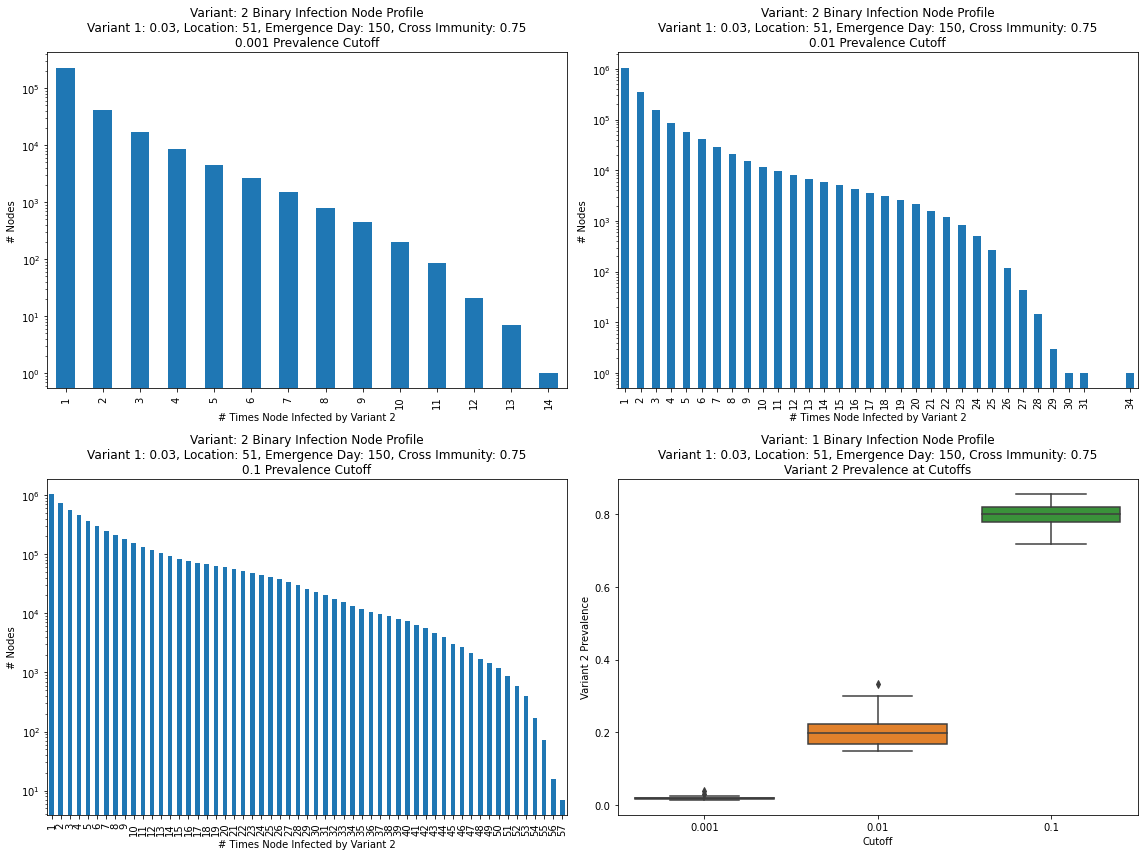

In [52]:
plot_scenario(scenarios[0], var=2)
plt.savefig("node_V2_binary_infection_profile_example.png", dpi=100, facecolor="white")

<ipython-input-41-96d22d845cad>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data[offset])


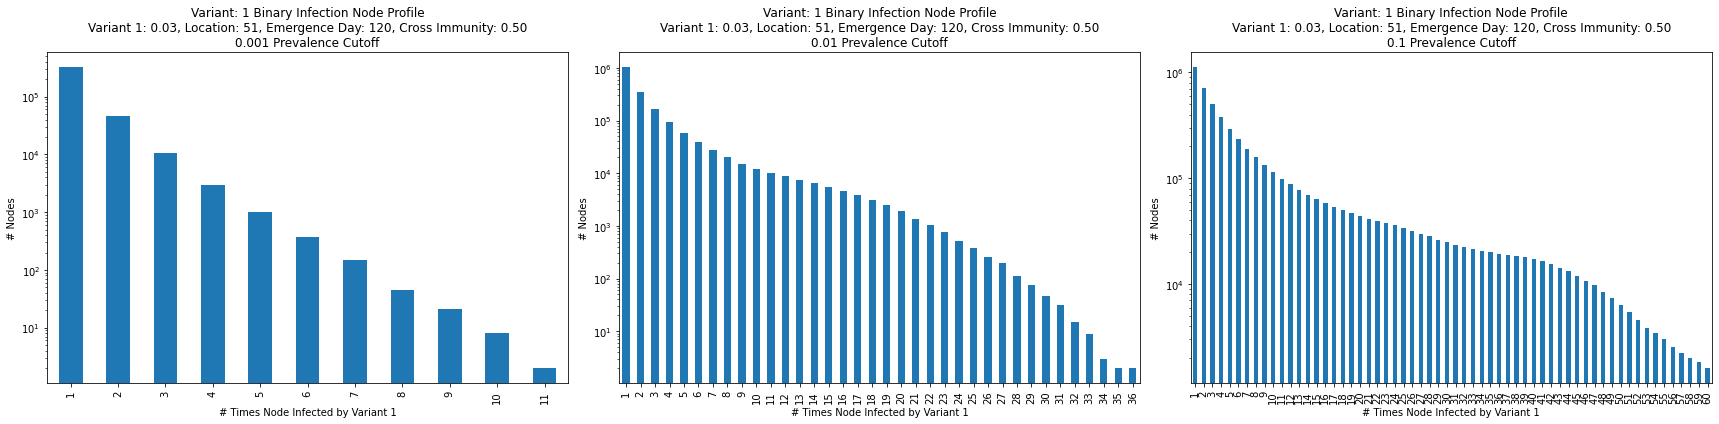

In [46]:
plot_scenario(scenarios[1], var=1)
plt.savefig("node_V1_binary_infection_profile_example.png", dpi=100, facecolor="white")

### Old Plots

<ipython-input-12-8a141320ae8a>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data[offset])


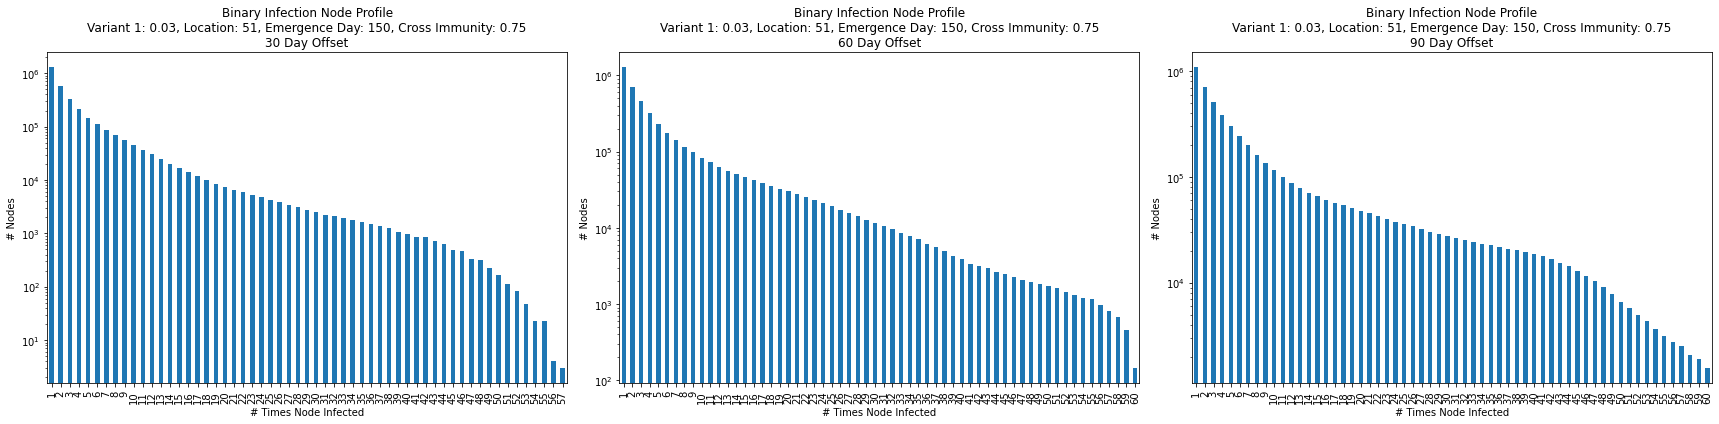

In [13]:
plot_old_scenario(scenarios[0])
plt.savefig("node_binary_infection_profile_example.png", dpi=100, facecolor="white")

<ipython-input-85-c09cd5060fc9>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(replicate_data[offset])


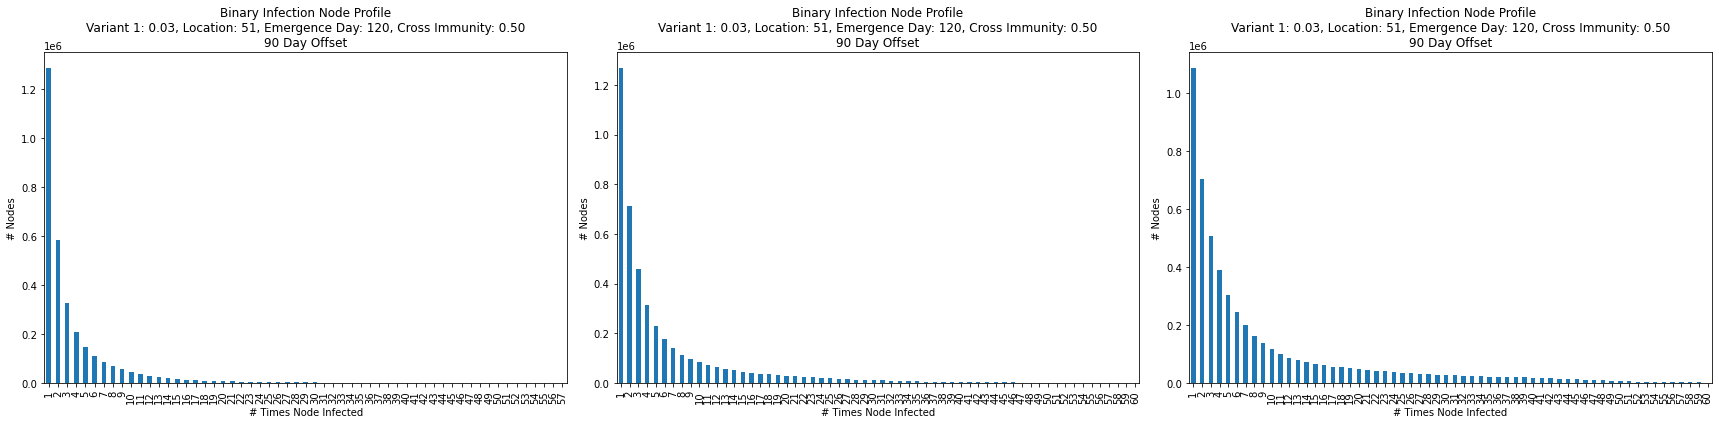

In [87]:
plot_old_scenario(scenarios[1])

<ipython-input-85-c09cd5060fc9>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(replicate_data[offset])


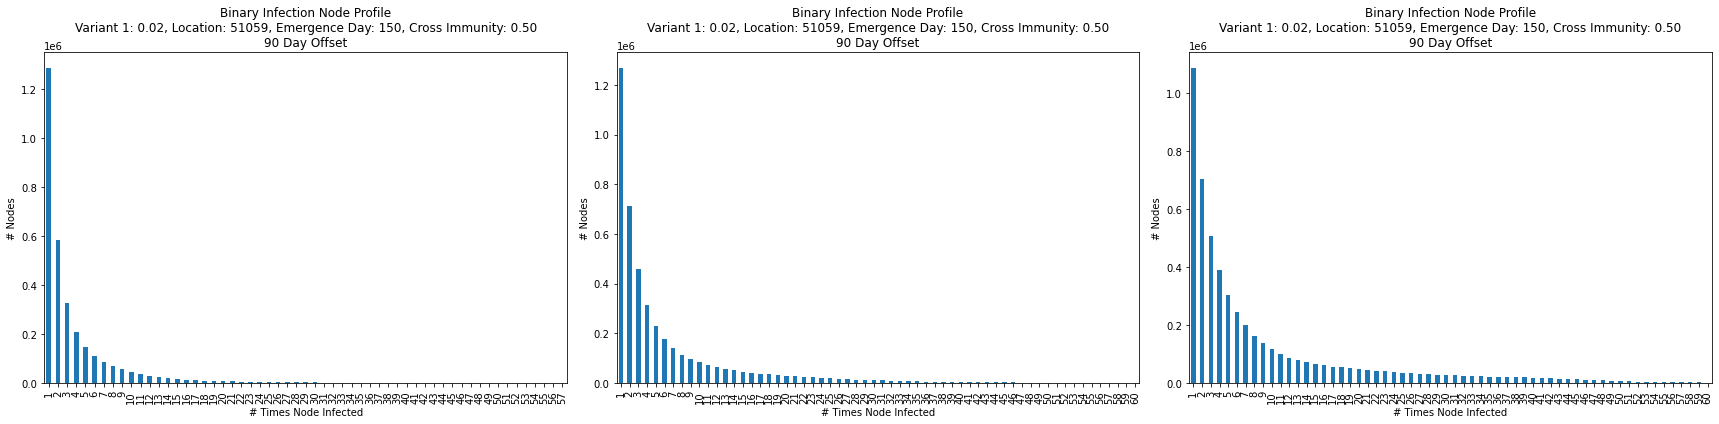

In [88]:
plot_old_scenario(scenarios[2])